In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd ./drive/My \Drive/PCD

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/PCD


In [0]:
#Load Everything and ensure that during changes items are reloaded
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#import fastai.. cheat and load everything!
import fastai
from fastai import *
#import fastai more specific
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks.hooks import *
import re
import scipy.ndimage
import gc
from gradcam import *
print(fastai.__version__)
print(torch.__version__)

1.0.55
1.1.0


In [0]:
#path to the data
path = Path('output'); path.ls()

[PosixPath('output/valid'),
 PosixPath('output/models'),
 PosixPath('output/train')]

In [0]:
data=None
gc.collect()

# We are using batchsize of 8
bs = 8
# This is what we want to flip and move around; we want to do just basic stuff at first
tfms = get_transforms()
# pulls and formats the data by looking for the
# path= where it is stored
# ds_tfms= the transforms we want of the images
# size= how big the images should be
# bs= batchsize that we can fit with the GPU Ram; Mine is 64 for 8gb
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs)
data.normalize(imagenet_stats)
# lists out the classes
data.classes

['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Cu', 'Ns', 'Sc', 'St']

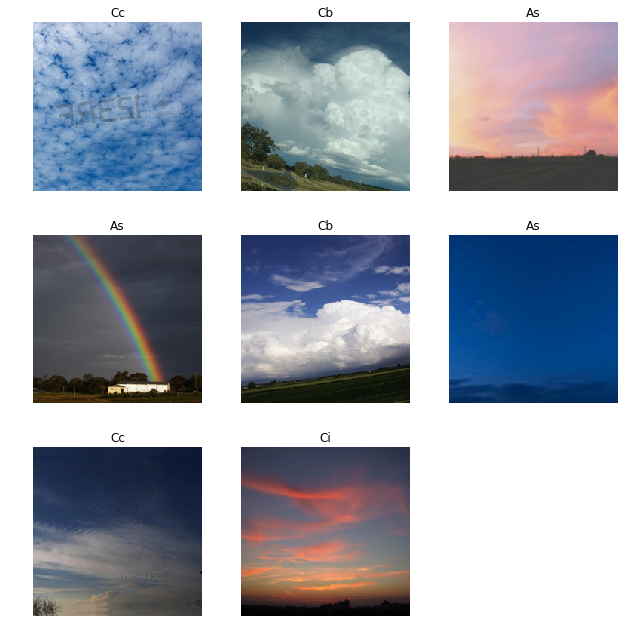

In [0]:
data.show_batch(rows=4, figsize=(9,9))

In [0]:
def reset_learner(data,is_fp16=False):
    learn=None
    gc.collect()
    learn = cnn_learner(data, models.densenet201, metrics=accuracy, callback_fns=ShowGraph)
    if is_fp16:
        learn = learn.to_fp16()
    return learn
# learn will be a convultional neural network (cnn) that takes in several items
# data = our images that have been setup
# architecture = is the model we are choosing. In this case Resnet34
# metrics = is how we are going to gauge success
learn = reset_learner(data)
learn.load('stage-2-d201')

In [0]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Valid)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [0]:
accuracy(interp.preds,torch.tensor(data.valid_ds.y.items))

tensor(0.9514)

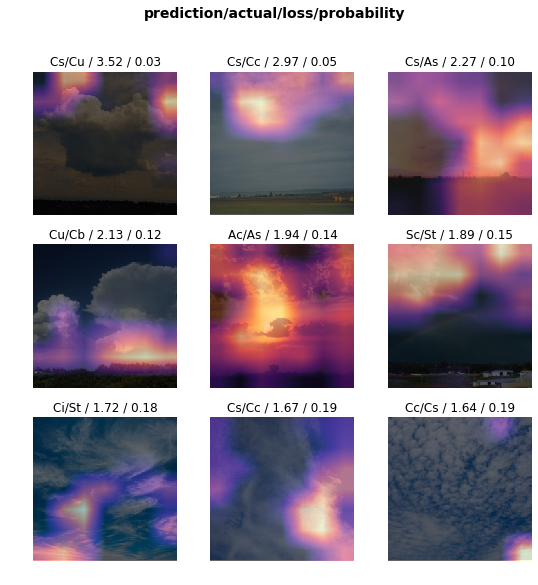

In [0]:
#Lists the top categories
interp.plot_top_losses(9, figsize=(9,9))

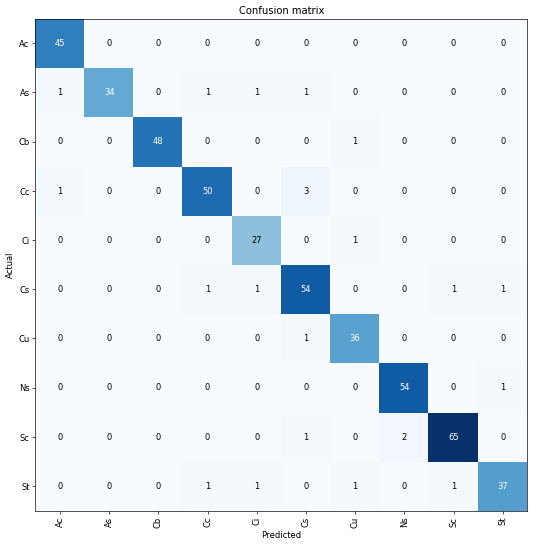

In [0]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(9,9), dpi=60)

In [0]:
#most confused
interp.most_confused(min_val=2)

[('Cc', 'Cs', 3), ('Sc', 'Ns', 2)]

cam

In [0]:
for idx in range(0,460,20):
    gcam = GradCam.from_interp(learn,interp,idx,include_label=True)
    gcam.plot()

In [0]:
def class2idx(clas):
    return data.classes.index(clas)
classes = data.classes
true_idx,pred_idx = class2idx('Cc'),class2idx('Cs')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
len(mismatch_idxs)

3

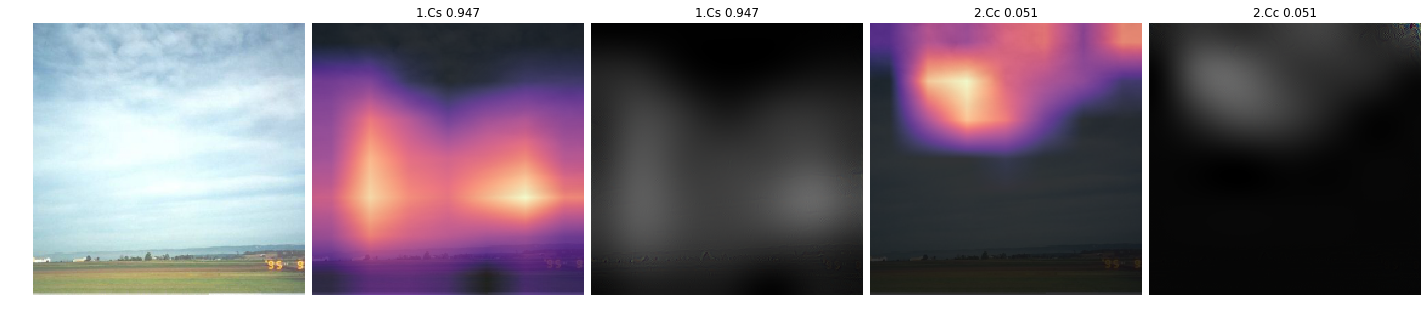

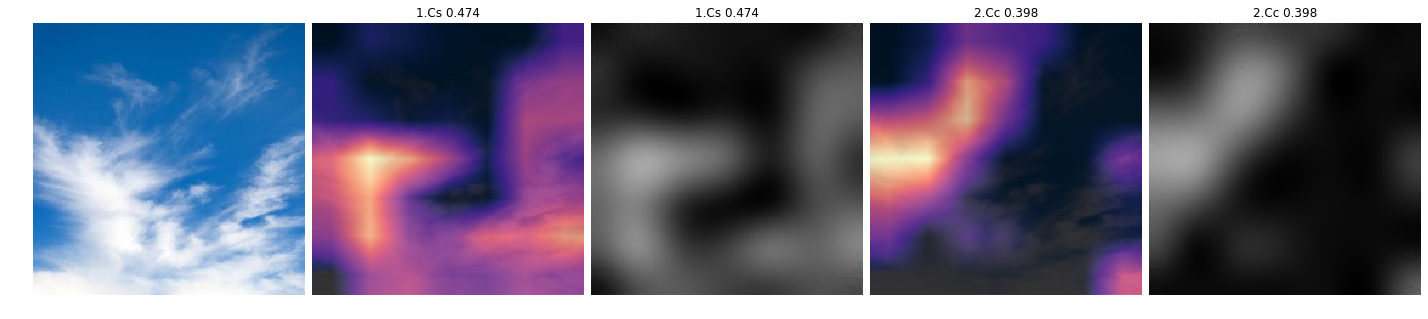

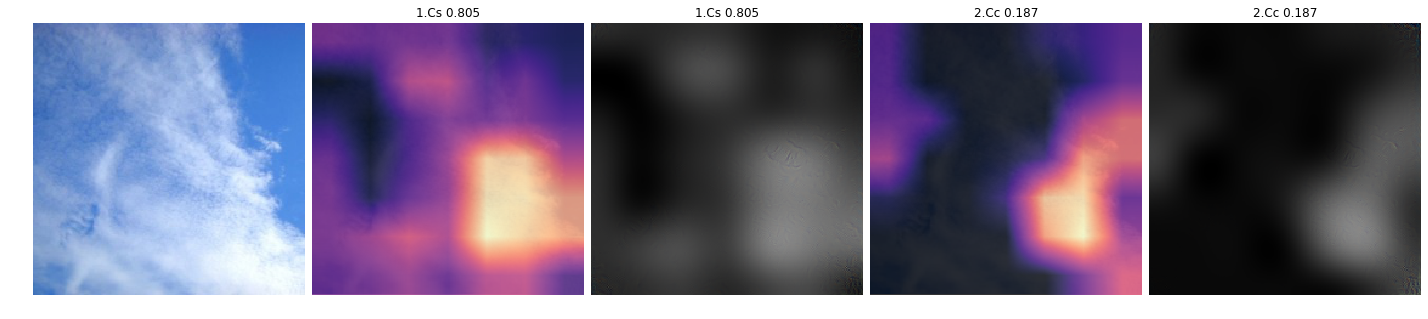

In [0]:
for idx in mismatch_idxs[:3]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=True)
    gcam.plot()

In [0]:
true_idx,pred_idx = class2idx('Sc'),class2idx('Ns')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
len(mismatch_idxs)

2

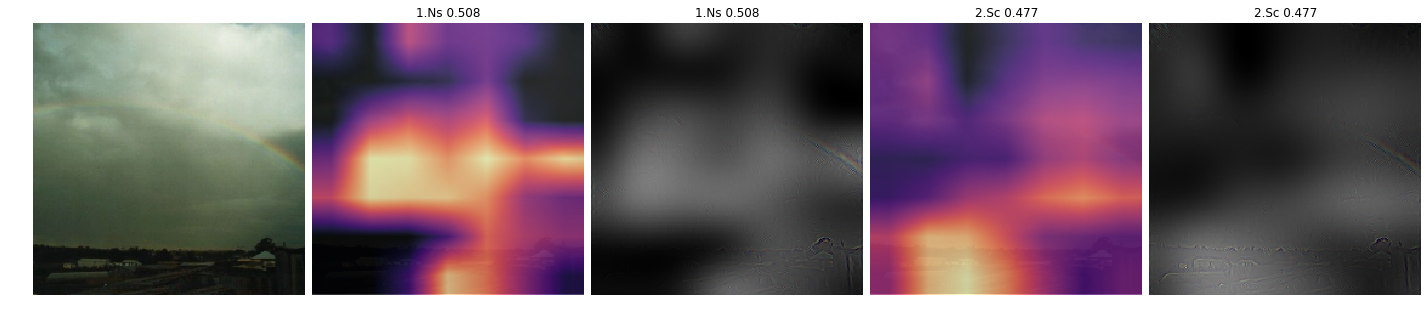

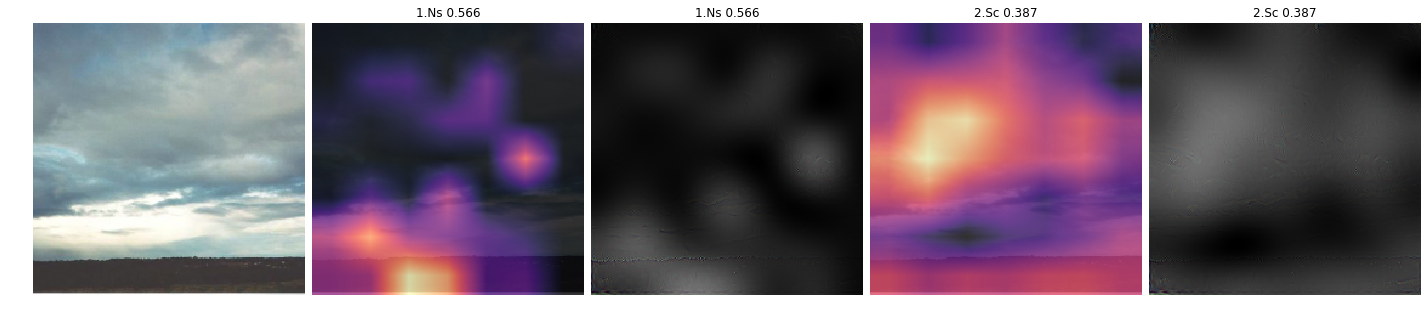

In [0]:
for idx in mismatch_idxs[:2]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=True)
    gcam.plot()